# Predictive Analysis

**Authors:** 
- Marc Villalonga Llobera
- Patxi Juaristi Pagegi

**Date:** 08/01/2024

---

This Jupyter Notebook covers the third task of the project for the Data Mining subject of the Laurea Magistrale of the University of Pisa, focused in predictive analysis.

## Environment preparation and data reading

First of all, we will install all the required packages, and then import the libraries that we will use:


In [111]:
%%capture
!python -m pip install --upgrade pip
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [112]:
# Import necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

After importing the required libraries, we will read the datasets that we have exported in the task 1, which they contain the data filtered after the data preparation tasks.

In [113]:
# Load the three datasets
incidents_dataset = pd.read_csv('../project_datasets/incidents_v2.csv', low_memory=False)

## New Feature Definition

First, we will define new feature that will enable classification for later predictions.

### Time related features

We will extract new features related with the moment that the incident occurred, based on the `date` column.

- Extract month, day of the week, and year.
- Create a feature for weekends or weekdays.
- Create a feature for the season (spring, summer, autumn, winter).

In [114]:
# Convert 'date' column to datetime format
incidents_dataset['date'] = pd.to_datetime(incidents_dataset['date'])

# Extract month, day of the week, and year
incidents_dataset['month'] = incidents_dataset['date'].dt.month
incidents_dataset['day_of_week'] = incidents_dataset['date'].dt.dayofweek
incidents_dataset['year'] = incidents_dataset['date'].dt.year

# Create a feature for weekends or weekdays
incidents_dataset['is_weekend'] = (incidents_dataset['date'].dt.weekday >= 5).astype(int)

# Create a feature for the season
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'

incidents_dataset['season'] = incidents_dataset['month'].apply(get_season)

# Display the updated DataFrame
print(incidents_dataset[['date', 'month', 'day_of_week', 'year', 'is_weekend', 'season']].head())


        date  month  day_of_week  year  is_weekend  season
0 2015-05-02      5            5  2015           1  spring
1 2017-04-03      4            0  2017           0  spring
2 2014-01-18      1            5  2014           1  winter
3 2018-01-25      1            3  2018           0  winter
4 2016-08-01      8            0  2016           0  summer


### Geographical and participant features

Then, we will create various new features that will take into account the state and city of the incident with the participant features.

First of all, we will count the number of incidents per state and per city.

In [115]:
# City and State Incident Count
incidents_dataset['city_incident_count'] = incidents_dataset.groupby('city_or_county')['city_or_county'].transform('count')
incidents_dataset['state_incident_count'] = incidents_dataset.groupby('state')['state'].transform('count')

print(incidents_dataset[['city_or_county','state', 'city_incident_count', 'state_incident_count']].head())

  city_or_county           state  city_incident_count  state_incident_count
0   Indianapolis         INDIANA                  941                  3566
1           Kane    PENNSYLVANIA                    3                  6149
2   Wayne County  NORTH CAROLINA                    9                  5090
3        Zachary       LOUISIANA                   10                  5374
4       Stafford        VIRGINIA                   41                  3311


Then, we will create two columns, one for the state and the other for the city, where we will define an index, to analyze the severity of the incidents per area. This severity is obtained by the sum of the killed and injured people.

In [116]:
# City and State Severity Index
incidents_dataset['city_severity_index'] = (incidents_dataset['n_killed'] + incidents_dataset['n_injured']) / incidents_dataset['city_incident_count']
incidents_dataset['state_severity_index'] = (incidents_dataset['n_killed'] + incidents_dataset['n_injured']) / incidents_dataset['state_incident_count']

print(incidents_dataset[['city_or_county','state', 'city_severity_index', 'state_severity_index']].head())

  city_or_county           state  city_severity_index  state_severity_index
0   Indianapolis         INDIANA             0.001063              0.000280
1           Kane    PENNSYLVANIA             0.333333              0.000163
2   Wayne County  NORTH CAROLINA             0.111111              0.000196
3        Zachary       LOUISIANA             0.300000              0.000558
4       Stafford        VIRGINIA             0.024390              0.000302


We will also add two columns for analyzing the average age of the participants on incidents per zone.

In [117]:
# City and State Average Age of Participants
incidents_dataset['city_avg_age'] = incidents_dataset.groupby('city_or_county')['avg_age_participants'].transform('mean')
incidents_dataset['state_avg_age'] = incidents_dataset.groupby('state')['avg_age_participants'].transform('mean')

print(incidents_dataset[['city_or_county', 'state', 'city_avg_age', 'state_avg_age']].head())

  city_or_county           state  city_avg_age  state_avg_age
0   Indianapolis         INDIANA     28.907545      30.124509
1           Kane    PENNSYLVANIA     36.666667      29.825175
2   Wayne County  NORTH CAROLINA     37.333333      30.119450
3        Zachary       LOUISIANA     33.700000      29.510421
4       Stafford        VIRGINIA     29.097561      29.313198


To conclude, since the female participation is quite lower than the male one, we will also add columns to get the female participation in each zone.

In [118]:
# City and State Female Participation Rate
incidents_dataset['city_female_participation_rate'] = (incidents_dataset['n_females'] / incidents_dataset['n_participants']) * 100
incidents_dataset['state_female_participation_rate'] = (incidents_dataset['n_females'] / incidents_dataset.groupby('state')['n_participants'].transform('sum')) * 100

print(incidents_dataset[['city_or_county', 'state', 'city_female_participation_rate', 'state_female_participation_rate']][4:12])

           city_or_county         state  city_female_participation_rate  \
4                Stafford      VIRGINIA                        0.000000   
5                   Tulsa      OKLAHOMA                      100.000000   
6                   Bronx      NEW YORK                        0.000000   
7   Kansas City (Raytown)      MISSOURI                        0.000000   
8                Hesperia    CALIFORNIA                        0.000000   
9                Longview         TEXAS                        0.000000   
10           Philadelphia  PENNSYLVANIA                       33.333333   
11            Los Angeles    CALIFORNIA                        0.000000   

    state_female_participation_rate  
4                          0.000000  
5                          0.028106  
6                          0.000000  
7                          0.000000  
8                          0.000000  
9                          0.000000  
10                         0.009240  
11                  

## Preprocessing

To start with the preprocessing, we will remove the columns that we will not use in the prediction.

In [119]:
# Drop unnecessary columns
columns_to_drop = ['date', 'address', 'notes', 'incident_characteristics2', 'latitude', 'longitude',
                   'min_age_participants', 'max_age_participants', 'congressional_district', 'state_house_district', 'state_senate_district']
incidents_dataset = incidents_dataset.drop(columns=columns_to_drop)

### Handle Categorical Variables

Then, we will impute the missing values in numerical columns using the average, and the mode for categorical missing values.

In [120]:
# Impute missing values in numerical columns with mean
numerical_columns = incidents_dataset.select_dtypes(include=['float64', 'int64']).columns
incidents_dataset[numerical_columns] = incidents_dataset[numerical_columns].fillna(incidents_dataset[numerical_columns].mean())

# Impute missing values in categorical columns with mode
categorical_columns = incidents_dataset.select_dtypes(include=['object']).columns
incidents_dataset[categorical_columns] = incidents_dataset[categorical_columns].fillna(incidents_dataset[categorical_columns].mode().iloc[0])

As we are going to predict if in an incident there have been at least a killed person or not, we will create a binary variable, which will say whether there have been deaths or not in the incidents of the dataset. This will be obtained from the variable `n_killed`, if it is greater than 0 it will be *True*, and if it is not, it will be *False*. The name of the variable will be `people_killed`

In [121]:
# Create a binary target variable 'has_fatality'
incidents_dataset['people_killed'] = (incidents_dataset['n_killed'] > 0).astype(int)

We start by specifying a dictionary `categorical_columns_to_encode` that indicates the categorical columns to be one-hot encoded along with their respective thresholds. We have set the thresholds to control the number of unique values retained for each categorical column during one-hot encoding and limit the categories just to the most relevant values, because including all values, makes the dataset too big, and we experienced memory problems during the analysis.

Moreover, analyzing incidents with very rare characteristics does not make sense. Anyway, columns like state, gender, age group or season do not have any threshold, because we want to include all of them. For example, age groups are just three, genders are two, and seasons are four, so it is unnecessary to limit the distinct values.

Afterwards, we go through the list of categorical columns and perform the one-hot encoding using `get_dummies` function. For each categorical column specified in the dictionary, we either include all unique values or select the top values based on the provided threshold. Any values not meeting the threshold are grouped into an "Other" category.

In [122]:
# Specify the columns for one-hot encoding along with their respective thresholds
categorical_columns_to_encode = {
    'state': None,  # Set to None to include all distinct values
    'city_or_county': 100,
    'participant_gender1': None,
    'participant_age_group1': None,
    'incident_characteristics1': 20,
    'season': None
}

# Perform one-hot encoding for categorical variables. Use sparse representation for one-hot encoding
for column, threshold in categorical_columns_to_encode.items():
    if threshold is None:
        top_values = incidents_dataset[column].unique()
    else:
        top_values = incidents_dataset[column].value_counts().nlargest(threshold).index
    incidents_dataset[column] = incidents_dataset[column].where(incidents_dataset[column].isin(top_values), 'Other')

incidents_dataset = pd.get_dummies(incidents_dataset, columns=categorical_columns_to_encode.keys(), sparse=True)

print(incidents_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146951 entries, 0 to 146950
Columns: 207 entries, participant_age1 to season_winter
dtypes: Sparse[bool, False](182), float64(16), int32(5), int64(4)
memory usage: 29.4 MB
None


### Feature Scaling

In [123]:
# Extract target variable 'y'
y = incidents_dataset['people_killed']

# Extract features 'X'
X = incidents_dataset.drop(columns=['n_killed', 'people_killed'])

# Convert the dataframe to a dense array
X_array = X.to_numpy()

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array)


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle = True)

# Check the shape of the resulting sets
print("\nTrain set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

C:\Users\patxi\AppData\Local\Temp\ipykernel_12444\273593792.py:8: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_array = X.to_numpy()



Train set shape: (117560, 205) (117560,)
Test set shape: (29391, 205) (29391,)


## Model Selection and Evaluation

Next section will focus on the model selection and evaluation. For that, we perform a classification task using five different classifiers: K-Nearest Neighbors (KNN), Naive Bayes, Support Vector Machines (SVM), Logistic Regression and Random Forest. Each classifier is instantiated and stored in a dictionary named classifiers. The LogisticRegression model is configured with a higher maximum number of iterations (max_iter=1000) to address potential convergence issues.

We iterate over each classifier, fitting the model to the training data (`X_train`, `y_train`) and making predictions on the test set (`X_test`). After predicting, we calculate various performance metrics, including accuracy, precision, recall, F1 score, and area under the ROC curve (AUC-ROC). These metrics are essential for evaluating how well each classifier performs on the test set.

Additionally, the code employs cross-validation (`cross_val_score`) with a 3-fold validation to assess the models robustly. Although this technique is time-consuming to obtain the results, it helps to estimate the performance on different subsets of the data, providing insights into its generalization ability.

The results, including individual metric scores, cross-validation AUC-ROC scores, and the mean cross-validation AUC-ROC, are printed for each classifier. This comprehensive evaluation allows for a comparison of the classifiers' performance and helps in selecting the most suitable model for the given classification task.

In [124]:
# Define the classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machines': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier()
}

# Create lists to store metrics for plotting
classifier_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
cv_mean_scores = []

# Iterate over classifiers
for clf_name, clf in classifiers.items():
    # Fit the model
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Evaluate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Cross-validation for more robust performance assessment
    cv_scores = cross_val_score(clf, X_scaled, y, cv=3, scoring='roc_auc')
    cv_mean = cv_scores.mean()

    # Append metrics to lists
    classifier_names.append(clf_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    cv_mean_scores.append(cv_mean)
    
    # Print results
    print(f"\nClassifier: {clf_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"Cross-Validation AUC-ROC Scores: {cv_scores}")
    print(f"Mean Cross-Validation AUC-ROC: {cv_scores.mean()}\n")


Classifier: K-Nearest Neighbors
Accuracy: 0.9377
Precision: 0.9469
Recall: 0.8521
F1 Score: 0.8970
AUC-ROC: 0.9149
Cross-Validation AUC-ROC Scores: [0.96096748 0.96050551 0.95872527]
Mean Cross-Validation AUC-ROC: 0.9600660873107834


Classifier: Naive Bayes
Accuracy: 0.6807
Precision: 0.4992
Recall: 0.9846
F1 Score: 0.6625
AUC-ROC: 0.7617
Cross-Validation AUC-ROC Scores: [0.76716025 0.77626493 0.76838842]
Mean Cross-Validation AUC-ROC: 0.7706045367276868


Classifier: Support Vector Machines
Accuracy: 0.9817
Precision: 0.9848
Recall: 0.9572
F1 Score: 0.9708
AUC-ROC: 0.9752
Cross-Validation AUC-ROC Scores: [0.99816824 0.99804533 0.99831373]
Mean Cross-Validation AUC-ROC: 0.9981757659073338


Classifier: Logistic Regression
Accuracy: 0.9896
Precision: 0.9814
Recall: 0.9861
F1 Score: 0.9837
AUC-ROC: 0.9887
Cross-Validation AUC-ROC Scores: [0.99758434 0.99764519 0.99741045]
Mean Cross-Validation AUC-ROC: 0.9975466615046752


Classifier: Random Forest
Accuracy: 0.9846
Precision: 0.9938
Re

Obtained results are summarized in the next table:

<center>

|        Classifier       | Accuracy | Precision | Recall | F1 Score | AUC-ROC | Cross-Validation AUC-ROC | Mean Cross-Validation AUC-ROC
|:------------------------|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
| **K-Nearest Neighbors**     |   0.9350   |   0.9471   |   0.8456   |   0.8935   |   0.9116   |   0.9606   |   0.9602   |
| **Naive Bayes**             |   0.6816   |   0.5030   | <span style="color:blue;">**0.9884**</span> |   0.6667   |   0.7620   |   0.7762   |   0.7706   |
| **Support Vector Machines** |   0.9811   |   0.9861   |   0.9549   |   0.9703   |   0.9743   |   0.9979   |   0.9980   |
| **Logistic Regression**     | <span style="color:blue;">**0.9888**</span> |   0.9796   |   0.9857   | <span style="color:blue;">**0.9826**</span> | <span style="color:blue;">**0.9880** |   0.9975   |   0.9974   |
| **Random Forest**           |   0.9845   | <span style="color:blue;">**0.9926**</span> |   0.9591   |   0.9756   |   0.9779   | <span style="color:blue;">**0.9993**</span> | <span style="color:blue;">**0.9991**</span> |

</center>

To see clearly the difference between the classifiers, we have made a plot which includes six subplots with the evaluation metrics that we tested before. Moreover, we have included an arrow for the classifier that has obtained the best result in each evaluation metric.

Analyzing the performance of various classifiers, it's evident that each model excels in different aspects. Logistic Regression and Random Forest showcase high precision, making them suitable for tasks where minimizing false positives is crucial. Naive Bayes, on the other hand, exhibit higher recall, making it favorable when capturing as many positive instances as possible is a priority. Support Vector Machines (SVM) and Logistic Regression stand out for their balanced performance across multiple metrics, making them strong contenders for scenarios where a harmonious blend of precision and recall is desired. By contrast, compared to the other classifiers, K-Nearest Neighbors obtained the worst results in all metrics.

Analyzing the set of results obtained in the different metrics, it can be said that the most complete classifier for this case is the Logistic Regression classifier.

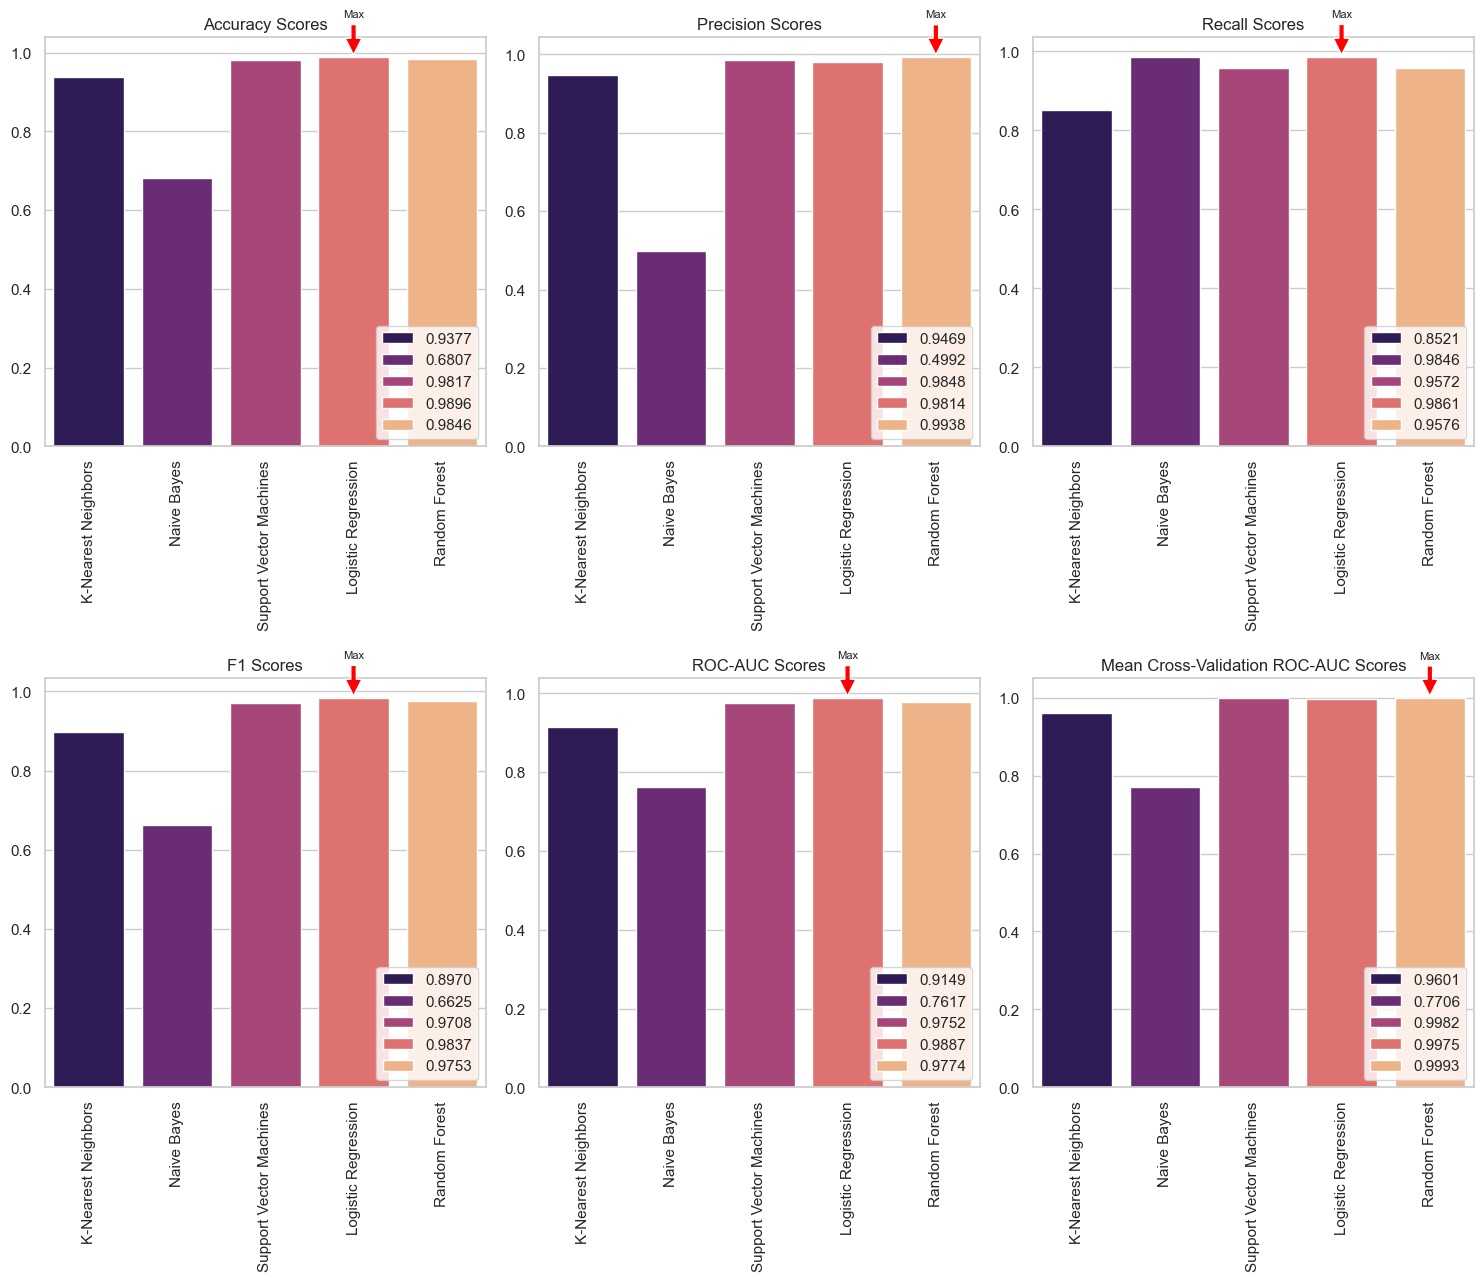

In [125]:
# Function to round scores and create legend labels
def round_and_label(scores):
    rounded_scores = np.round(scores, 4)
    return [f'{score:.4f}' for score in rounded_scores]

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 13))

# Accuracy Plot
plt.subplot(2, 3, 1)
sns.barplot(x=classifier_names, y=accuracy_scores, palette="magma", hue=round_and_label(accuracy_scores))
max_index = np.argmax(accuracy_scores)
plt.annotate('Max', xy=(max_index, accuracy_scores[max_index]), xytext=(max_index, max(accuracy_scores) + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=8, ha='center')
plt.title("Accuracy Scores")
plt.xticks(rotation=90)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Precision Plot
plt.subplot(2, 3, 2)
sns.barplot(x=classifier_names, y=precision_scores, palette="magma", hue=round_and_label(precision_scores))
max_index = np.argmax(precision_scores)
plt.annotate('Max', xy=(max_index, precision_scores[max_index]), xytext=(max_index, max(precision_scores) + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=8, ha='center')
plt.title("Precision Scores")
plt.xticks(rotation=90)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Recall Plot
plt.subplot(2, 3, 3)
sns.barplot(x=classifier_names, y=recall_scores, palette="magma", hue=round_and_label(recall_scores))
max_index = np.argmax(recall_scores)
plt.annotate('Max', xy=(max_index, recall_scores[max_index]), xytext=(max_index, max(recall_scores) + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=8, ha='center')
plt.title("Recall Scores")
plt.xticks(rotation=90)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# F1 Score Plot
plt.subplot(2, 3, 4)
sns.barplot(x=classifier_names, y=f1_scores, palette="magma", hue=round_and_label(f1_scores))
max_index = np.argmax(f1_scores)
plt.annotate('Max', xy=(max_index, f1_scores[max_index]), xytext=(max_index, max(f1_scores) + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=8, ha='center')
plt.title("F1 Scores")
plt.xticks(rotation=90)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# ROC-AUC Plot
plt.subplot(2, 3, 5)
sns.barplot(x=classifier_names, y=roc_auc_scores, palette="magma", hue=round_and_label(roc_auc_scores))
max_index = np.argmax(roc_auc_scores)
plt.annotate('Max', xy=(max_index, roc_auc_scores[max_index]), xytext=(max_index, max(roc_auc_scores) + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=8, ha='center')
plt.title("ROC-AUC Scores")
plt.xticks(rotation=90)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Cross-Validation Mean ROC-AUC Plot
plt.subplot(2, 3, 6)
sns.barplot(x=classifier_names, y=cv_mean_scores, palette="magma", hue=round_and_label(cv_mean_scores))
max_index = np.argmax(cv_mean_scores)
plt.annotate('Max', xy=(max_index, cv_mean_scores[max_index]), xytext=(max_index, max(cv_mean_scores) + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=8, ha='center')
plt.title("Mean Cross-Validation ROC-AUC Scores")
plt.xticks(rotation=90)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

## Data Export

We will export the modified dataset to *.csv* files, because we will use it in the next task related to the time series analysis, since we need the `people_killed` variable.

In [126]:
incidents_dataset.to_csv('../project_datasets/incidents_v3.csv', index=False)